# Tracing Executions

In this chapter, we show how to observe program state during an execution – a prerequisite for logging and interactive debugging. Thanks to the power of Python, we can do this in a few lines of code.

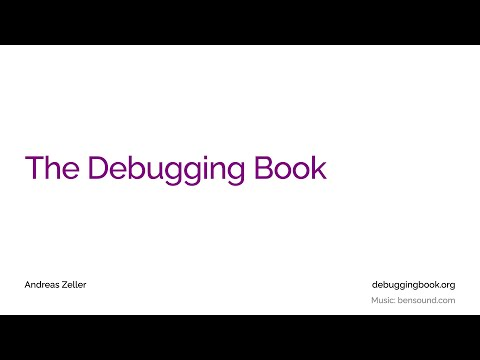

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo("UYAvCl-5NGY")

**Prerequisites**

* You should have read the [Introduction to Debugging](Intro_Debugging.ipynb).
* Knowing a bit of _Python_ is helpful for understanding the code examples in the book.

In [2]:
import bookutils

In [3]:
from bookutils import quiz

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.Tracer import <identifier>
```

and then make use of the following features.


This chapter provides a `Tracer()` class that allows to log events during program execution.

The advanced subclass `EventTracer` allows to restrict logs to specific conditions. Logs are shown only while the given `condition` holds:

```python
>>> with EventTracer(condition='line == 223 or len(out) >= 6'):
>>>     remove_html_markup('<b>foo</b>bar')
...
                                         # s = '<b>foo</b>bar', function = 'remove_html_markup', line = 157, tag = False, quote = False, out = 'foobar', c = 'r'
157     for c in s:
                                         # line = 169
169     return out
remove_html_markup() returns 'foobar'
```
It also allows to restrict logs to specific events. Log entries are shown only if one of the given `events` changes its value:

```python
>>> with EventTracer(events=["c == '/'"]):
>>>     remove_html_markup('<b>foo</b>bar')
...
Calling remove_html_markup(s = '<b>foo</b>bar', function = 'remove_html_markup', line = 152)
...
                                         # line = 158, tag = False, quote = False, out = '', c = '<'
158         assert tag or not quote
...
                                         # tag = True, out = 'foo', c = '/'
158         assert tag or not quote
...
                                         # c = 'b'
158         assert tag or not quote
```
`Tracer` and `EventTracer` classes allow for subclassing and further customization.



## Tracing Python Programs

How do debugging tools access the state of a program during execution? For _interpreted_ languages such as Python, this is a fairly simple task. If a language is interpreted, it is typically fairly easy to control execution and to inspect state – since this is what the interpreter is doing already anyway. Debuggers are then implemented in top of _hooks_ that allow to interrupt execution and access program state.

Python makes such a hook available in the function `sys.settrace()`. You invoke it with a *tracing function* that will be called at every line executed, as in

```python
sys.settrace(traceit)
```

Such a tracing function is convenient, as it simply traces _everything_. In contrast to an interactive debugger, where you have to select which aspect of the execution you're interested in, you can just print out a long trace into an *execution log*, to examine it later.

This tracing function takes the format

In [4]:
def traceit(frame, event, arg):
    ...

Here, `event` is a string telling what has happened in the program – for instance,

* `'line'` – a new line is executed
* `'call'` – a function just has been called
* `'return'` – a function returns

The `frame` argument holds the current execution frame – that is, the function and its local variables:

* `frame.f_lineno` – the current line
* `frame.f_locals` – the current variables (as a Python dictionary)
* `frame.f_code` – the current code (as a Code object), with attributes such as
    * `frame.f_code.co_name` – the name of the current function

We can thus get a *trace* of the program by simply printing out these values:

In [5]:
def traceit(frame, event, arg):
    print(event, frame.f_lineno, frame.f_code.co_name, frame.f_locals)

The return value of the trace function is the function to be executed at the next event – typically, this is the function itself:

In [6]:
def traceit(frame, event, arg):
    print(event, frame.f_lineno, frame.f_code.co_name, frame.f_locals)
    return traceit

Let us try this out on the `remove_html_markup()` function introduced in the [Introduction to Debugging](Intro_Debugging.ipynb):

In [7]:
from Intro_Debugging import remove_html_markup

In [8]:
import inspect

In [9]:
from bookutils import print_content

In [10]:
content, start_line_number = inspect.getsourcelines(remove_html_markup)
print_content(content="".join(content).strip(), filename='.py', start_line_number=start_line_number)

152  def remove_html_markup(s):
153      tag = False
154      quote = False
155      out = ""
156  
157      for c in s:
158          assert tag or not quote
159  
160          if c == '<' and not quote:
161              tag = True
162          elif c == '>' and not quote:
163              tag = False
164          elif (c == '"' or c == "'") and tag:
165              quote = not quote
166          elif not tag:
167              out = out + c
168  
169      return out

We define a variant `remove_html_markup_traced()` which turns on tracing, invokes `remove_html_markup()`, and turns tracing off again.

In [11]:
import sys

In [12]:
def remove_html_markup_traced(s):
    sys.settrace(traceit)
    ret = remove_html_markup(s)
    sys.settrace(None)
    return ret

In [13]:
remove_html_markup_traced('xyz')

call 152 remove_html_markup {'s': 'xyz'}
line 153 remove_html_markup {'s': 'xyz'}
line 154 remove_html_markup {'s': 'xyz', 'tag': False}
line 155 remove_html_markup {'s': 'xyz', 'tag': False, 'quote': False}
line 157 remove_html_markup {'s': 'xyz', 'tag': False, 'quote': False, 'out': ''}
line 158 remove_html_markup {'s': 'xyz', 'tag': False, 'quote': False, 'out': '', 'c': 'x'}
line 160 remove_html_markup {'s': 'xyz', 'tag': False, 'quote': False, 'out': '', 'c': 'x'}
line 162 remove_html_markup {'s': 'xyz', 'tag': False, 'quote': False, 'out': '', 'c': 'x'}
line 164 remove_html_markup {'s': 'xyz', 'tag': False, 'quote': False, 'out': '', 'c': 'x'}
line 166 remove_html_markup {'s': 'xyz', 'tag': False, 'quote': False, 'out': '', 'c': 'x'}
line 167 remove_html_markup {'s': 'xyz', 'tag': False, 'quote': False, 'out': '', 'c': 'x'}
line 157 remove_html_markup {'s': 'xyz', 'tag': False, 'quote': False, 'out': 'x', 'c': 'x'}
line 158 remove_html_markup {'s': 'xyz', 'tag': False, 'quote': F

'xyz'

In this very raw format, we can see how the execution progresses through the function. The variable `c` takes one character of the input string at a time; the `out` variable accumulates them. The argument `s` and the `tag` and `quote` flags stay unchanged throughout the execution.

In [14]:
import math

In [15]:
quiz("What happens if the tracing function returns None"
     " while tracing function f()?"
     " Lookup sys.setttrace() in the Python documentation"
     " or try it out yourself.",
     ['Tracing stops for all functions;'
      ' the tracing function is no longer called',
      'Tracing stops for f(): the tracing function is called when f() returns',
      'Tracing stops for f() the rest of the execution: the tracing function'
      ' is no longer called for calls to f()',
      'Nothing changes'], math.log(7.38905609893065))

## A Tracer Class

Let us refine our tracing function a bit. First, it would be nice if one could actually _customize_ tracing just as needed. To this end, we introduce a `Tracer` class that does all the formatting with us, and which can be _subclassed_ to allow for different output formats.

The `traceit()` method is the same as above, and again is added set up via `sys.settrace()`. Its typical usage, however, is as follows:

```python
with Tracer():
    # Code to be traced
    ...

# Code no longer traced
...
```

When the `with` statement is encountered, the `__enter__()` method is called, which starts tracing. When the `with` block ends, the `__exit__()` method is called, and tracing is turned off. We take special care that the internal `__exit__()` method is not part of the trace, and that any other tracing function that was active before is being restored.

In [16]:
class Tracer(object):
    def __init__(self, file=sys.stdout):
        """Trace a block of code, sending logs to file (default: stdout)"""
        self.original_trace_function = None
        self.file = file
        pass

    def log(self, *objects, sep=' ', end='\n', flush=False):
        """Like print(), but always sending to file given at initialization,
           and always flushing"""
        print(*objects, sep=sep, end=end, file=self.file, flush=True)

    def traceit(self, frame, event, arg):
        """Tracing function. To be overridden in subclasses."""
        self.log(event, frame.f_lineno, frame.f_code.co_name, frame.f_locals)

    def _traceit(self, frame, event, arg):
        """Internal tracing function."""
        if frame.f_code.co_name == '__exit__':
            # Do not trace our own __exit__() method
            pass
        else:
            self.traceit(frame, event, arg)
        return self._traceit

    def __enter__(self):
        """Called at begin of `with` block. Turn tracing on."""
        self.original_trace_function = sys.gettrace()
        sys.settrace(self._traceit)

    def __exit__(self, tp, value, traceback):
        """Called at begin of `with` block. Turn tracing off."""
        sys.settrace(self.original_trace_function)

Here's how we use the `Tracer` class. You see that everything works as before, except that it is nicer to use:

In [17]:
with Tracer():
    remove_html_markup("abc")

call 152 remove_html_markup {'s': 'abc'}
line 153 remove_html_markup {'s': 'abc'}
line 154 remove_html_markup {'s': 'abc', 'tag': False}
line 155 remove_html_markup {'s': 'abc', 'tag': False, 'quote': False}
line 157 remove_html_markup {'s': 'abc', 'tag': False, 'quote': False, 'out': ''}
line 158 remove_html_markup {'s': 'abc', 'tag': False, 'quote': False, 'out': '', 'c': 'a'}
line 160 remove_html_markup {'s': 'abc', 'tag': False, 'quote': False, 'out': '', 'c': 'a'}
line 162 remove_html_markup {'s': 'abc', 'tag': False, 'quote': False, 'out': '', 'c': 'a'}
line 164 remove_html_markup {'s': 'abc', 'tag': False, 'quote': False, 'out': '', 'c': 'a'}
line 166 remove_html_markup {'s': 'abc', 'tag': False, 'quote': False, 'out': '', 'c': 'a'}
line 167 remove_html_markup {'s': 'abc', 'tag': False, 'quote': False, 'out': '', 'c': 'a'}
line 157 remove_html_markup {'s': 'abc', 'tag': False, 'quote': False, 'out': 'a', 'c': 'a'}
line 158 remove_html_markup {'s': 'abc', 'tag': False, 'quote': F

## Accessing Source Code

We cam now go and _extend_ the class with additional features. It would be nice if it could actually display the source code of the function being tracked, such that we know where we are. In Python, the function `inspect.getsource()` returns the source code of a function or module. Looking up

```python
module = inspect.getmodule(frame.f_code)
```

gives us the current module, and

```python
inspect.getsource(module)
```

gives us its source code. All we then have to do is to retrieve the current line.

To implement our extended `traceit()` method, we use a bit of a hack. The Python language requires us to define an entire class with all methods as a single, continuous unit; however, we would like to introduce one method after another.  To avoid this problem, we use a special hack: Whenever we want to introduce a new method to some class `C`, we use the construct

```python
class C(C):
    def new_method(self, args):
        pass
```

This seems to define `C` as a subclass of itself, which would make no sense – but actually, it introduces a new `C` class as a subclass of the _old_ `C` class, and then shadowing the old `C` definition.  What this gets us is a `C` class with `new_method()` as a method, which is just what we want.  (`C` objects defined earlier will retain the earlier `C` definition, though, and thus must be rebuilt.)

Using this hack, we can now redefine the `traceit()` method. Our new tracer shows the current line as it is executed.

In [18]:
import inspect

In [19]:
class Tracer(Tracer):
    def traceit(self, frame, event, arg):
        if event == 'line':
            module = inspect.getmodule(frame.f_code)
            if module is None:
                source = inspect.getsource(frame.f_code)
            else:
                source = inspect.getsource(module)
            current_line = source.split('\n')[frame.f_lineno - 1]
            self.log(frame.f_lineno, current_line)

        return traceit

In [20]:
with Tracer():
    remove_html_markup("abc")

153     tag = False
154     quote = False
155     out = ""
157     for c in s:
158         assert tag or not quote
160         if c == '<' and not quote:
162         elif c == '>' and not quote:
164         elif (c == '"' or c == "'") and tag:
166         elif not tag:
167             out = out + c
157     for c in s:
158         assert tag or not quote
160         if c == '<' and not quote:
162         elif c == '>' and not quote:
164         elif (c == '"' or c == "'") and tag:
166         elif not tag:
167             out = out + c
157     for c in s:
158         assert tag or not quote
160         if c == '<' and not quote:
162         elif c == '>' and not quote:
164         elif (c == '"' or c == "'") and tag:
166         elif not tag:
167             out = out + c
157     for c in s:
169     return out


## Tracing Calls and Returns

Next, we'd like to report calling and returning from functions. For the `return` event, `arg` holds the value being returned.

In [21]:
class Tracer(Tracer):
    def traceit(self, frame, event, arg):
        if event == 'call':
            self.log(f"Calling {frame.f_code.co_name}()")

        if event == 'line':
            module = inspect.getmodule(frame.f_code)
            source = inspect.getsource(module)
            current_line = source.split('\n')[frame.f_lineno - 1]
            self.log(frame.f_lineno, current_line)

        if event == 'return':
            self.log(f"{frame.f_code.co_name}() returns {repr(arg)}")

        return traceit

In [22]:
with Tracer():
    remove_html_markup("abc")

Calling remove_html_markup()
153     tag = False
154     quote = False
155     out = ""
157     for c in s:
158         assert tag or not quote
160         if c == '<' and not quote:
162         elif c == '>' and not quote:
164         elif (c == '"' or c == "'") and tag:
166         elif not tag:
167             out = out + c
157     for c in s:
158         assert tag or not quote
160         if c == '<' and not quote:
162         elif c == '>' and not quote:
164         elif (c == '"' or c == "'") and tag:
166         elif not tag:
167             out = out + c
157     for c in s:
158         assert tag or not quote
160         if c == '<' and not quote:
162         elif c == '>' and not quote:
164         elif (c == '"' or c == "'") and tag:
166         elif not tag:
167             out = out + c
157     for c in s:
169     return out
remove_html_markup() returns 'abc'


## Tracing Variable Changes

Finally, we'd again like to report variables – but only those that have changed. To this end, we save a copy of the last reported variables in the class, reporting only the changed values.

In [23]:
class Tracer(Tracer):
    def __init__(self, file=sys.stdout):
        self.last_vars = {}
        super().__init__(file=file)

    def changed_vars(self, new_vars):
        changed = {}
        for var_name in new_vars:
            if (var_name not in self.last_vars or
                    self.last_vars[var_name] != new_vars[var_name]):
                changed[var_name] = new_vars[var_name]
        self.last_vars = new_vars.copy()
        return changed

Here's how this works: If variable `a` is set to 10 (and we didn't have it so far), it is marked as changed:

In [24]:
t = Tracer()

In [25]:
t.changed_vars({'a': 10})

{'a': 10}

If another variable `b` is added, and only `b` is changed, then only `b` is marked as changed:

In [26]:
t.changed_vars({'a': 10, 'b': 25})

{'b': 25}

If both variables keep their values, nothing changes:

In [27]:
t.changed_vars({'a': 10, 'b': 25})

{}

But if new variables come along, they are listed again.

In [28]:
changes = t.changed_vars({'c': 10, 'd': 25})
changes

{'c': 10, 'd': 25}

The following expression creates a comma-separated list of variables and values:

In [29]:
", ".join([var + " = " + repr(changes[var]) for var in changes])

'c = 10, d = 25'

We can now put all of this together in our tracing function, reporting any variable changes as we see them. Note how we exploit the fact that in a call, all variables have a "new" value; and when we return from a function, we explicitly delete the "last" variables.

In [30]:
class Tracer(Tracer):
    def print_debugger_status(self, frame, event, arg):
        changes = self.changed_vars(frame.f_locals)
        changes_s = ", ".join([var + " = " + repr(changes[var])
                               for var in changes])

        if event == 'call':
            self.log("Calling " + frame.f_code.co_name + '(' + changes_s + ')')
        elif changes:
            self.log(' ' * 40, '#', changes_s)

        if event == 'line':
            module = inspect.getmodule(frame.f_code)
            if module is None:
                source = inspect.getsource(frame.f_code)
            else:
                source = inspect.getsource(module)
            current_line = source.split('\n')[frame.f_lineno - 1]
            self.log(repr(frame.f_lineno) + ' ' + current_line)

        if event == 'return':
            self.log(frame.f_code.co_name + '()' + " returns " + repr(arg))
            self.last_vars = {}  # Delete 'last' variables

    def traceit(self, frame, event, arg):
        self.print_debugger_status(frame, event, arg)

Here's the resulting trace of `remove_html_markup()` for a more complex input. You can see that the tracing output allows us to see which lines are executed as well as the variables whose value changes.

In [31]:
with Tracer():
    remove_html_markup('<b>x</b>')

Calling remove_html_markup(s = '<b>x</b>')
153     tag = False
                                         # tag = False
154     quote = False
                                         # quote = False
155     out = ""
                                         # out = ''
157     for c in s:
                                         # c = '<'
158         assert tag or not quote
160         if c == '<' and not quote:
161             tag = True
                                         # tag = True
157     for c in s:
                                         # c = 'b'
158         assert tag or not quote
160         if c == '<' and not quote:
162         elif c == '>' and not quote:
164         elif (c == '"' or c == "'") and tag:
166         elif not tag:
157     for c in s:
                                         # c = '>'
158         assert tag or not quote
160         if c == '<' and not quote:
162         elif c == '>' and not quote:
163             tag = False
                              

As you see, even a simple function can create a long execution log. Hence, we will now explore how to focus tracing on particular _events_.

## Conditional Tracing

A log such as the above can very quickly become very messy – notably if executions take a long time, or if data structures become very complex. If one of our local variables were a list with 1,000 entries for instance, and were changed with each line, we'd be printing out the entire list with 1,000 entries for each step. 

We could still load the log into, say, a text editor or a database and then search for specific values, but this is still cumbersome – and expensive. A better alternative, however, is to have our tracer only log while specific _conditions_ hold.

To this end, we introduce a class `ConditionalTracer`, which gets a _conditional expression_ to be checked during executions. Only if this condition holds do we list the current status. With

```python
with ConditionalTracer(condition='c == "z"'):
    remove_html_markup(...)
```

we would obtain only the lines executed while `c` gets a value of `'z'`, and with

```python
with ConditionalTracer(condition='quote'):
    remove_html_markup(...)
```

we would obtain only the lines executed while `quote` is True. If we have multiple conditions, we can combine them into one using `and`, `or`, or `not`.

Our `ConditionalTracer` class stores the condition in its `condition` attribute:

In [32]:
class ConditionalTracer(Tracer):
    def __init__(self, file=sys.stdout, condition=None):
        if condition is None:
            condition = "False"
        self.condition = condition
        self.last_report = None
        super().__init__(file=file)

Its `traceit()` function _evaluates_ `condition` and reports the current line only if it holds. To this end, it uses the Python `eval()` function which evaluates the condition in the context of the local variables of the program under test. If the condition gets set, we print out three dots to indicate the elapsed time.

In [33]:
class ConditionalTracer(ConditionalTracer):
    def eval_in_context(self, expr, frame):
        try:
            cond = eval(expr, None, frame.f_locals)
        except NameError:  # (yet) undefined variable
            cond = None
        return cond

The `do_report()` function returns True if the status is to be reported:

In [34]:
class ConditionalTracer(ConditionalTracer):
    def do_report(self, frame, event, arg):
        return self.eval_in_context(self.condition, frame)

We put everything together in our `traceit()` function:

In [35]:
class ConditionalTracer(ConditionalTracer):
    def traceit(self, frame, event, arg):
        report = self.do_report(frame, event, arg)
        if report != self.last_report:
            if report:
                self.log("...")
            self.last_report = report

        if report:
            self.print_debugger_status(frame, event, arg)

Here's an example. We see that `quote` is set only while the three characters `b`, `a`, and `r` are processed (as should be).

In [36]:
with ConditionalTracer(condition='quote'):
    remove_html_markup('<b title="bar">"foo"</b>')

...
                                         # s = '<b title="bar">"foo"</b>', tag = True, quote = True, out = '', c = '"'
157     for c in s:
                                         # c = 'b'
158         assert tag or not quote
160         if c == '<' and not quote:
162         elif c == '>' and not quote:
164         elif (c == '"' or c == "'") and tag:
166         elif not tag:
157     for c in s:
                                         # c = 'a'
158         assert tag or not quote
160         if c == '<' and not quote:
162         elif c == '>' and not quote:
164         elif (c == '"' or c == "'") and tag:
166         elif not tag:
157     for c in s:
                                         # c = 'r'
158         assert tag or not quote
160         if c == '<' and not quote:
162         elif c == '>' and not quote:
164         elif (c == '"' or c == "'") and tag:
166         elif not tag:
157     for c in s:
                                         # c = '"'
158         assert t

In [37]:
quiz("What happens if the condition contains a syntax error?",
     [
         "The tracer stops, raising an exception",
         "The tracer continues as if the condition were True",
         "The tracer continues as if the condition were False",
     ], 393 % 7)

Here's the answer, illustrated in two examples. For syntax errors, we indeed get an exception:

In [38]:
from ExpectError import ExpectError

In [39]:
with ExpectError():
    with ConditionalTracer(condition='2 +'):
        remove_html_markup('<b title="bar">"foo"</b>')

Traceback (most recent call last):
  File "<ipython-input-39-fac211775813>", line 3, in <module>
    remove_html_markup('<b title="bar">"foo"</b>')
  File "Intro_Debugging.ipynb", line 152, in remove_html_markup
    def remove_html_markup(s):
  File "<ipython-input-16-5072e7687ceb>", line 23, in _traceit
    self.traceit(frame, event, arg)
  File "<ipython-input-35-323ad3e5dd77>", line 3, in traceit
    report = self.do_report(frame, event, arg)
  File "<ipython-input-34-2ae15b24ca05>", line 3, in do_report
    return self.eval_in_context(self.condition, frame)
  File "<ipython-input-33-bdf362de870d>", line 4, in eval_in_context
    cond = eval(expr, None, frame.f_locals)
  File "<string>", line 1
    2 +
      ^
SyntaxError: unexpected EOF while parsing (expected)


If a variable is undefined, though, the condition evaluates to False:

In [40]:
with ExpectError():
    with ConditionalTracer(condition='undefined_variable'):
        remove_html_markup('<b title="bar">"foo"</b>')

We can also have the log focus on _particular code locations_ only. To this end, we add the pseudo-variables `function` and `line` to our evaluation context, which can be used within our condition to refer to the current function name or line. Then, we invoke the original `eval_cond()` as above.

In [41]:
class ConditionalTracer(ConditionalTracer):
    def eval_in_context(self, expr, frame):
        frame.f_locals['function'] = frame.f_code.co_name
        frame.f_locals['line'] = frame.f_lineno

        return super().eval_in_context(expr, frame)

Again, here is an example. We focus on the parts of the function where the `out` variable is being set:

In [42]:
with ConditionalTracer("function == 'remove_html_markup' and line >= 237"):
    remove_html_markup('xyz')

Using `line` and `function` in conditions is equivalent to conventional _breakpoints_ in interactive debuggers. We will reencounter them in the next chapter.

In [43]:
quiz("If the program under test contains a variable named 'line', "
     "which 'line' does the condition refer to?",
     ["'line' as in the debugger", "'line' as in the program"],
     (326 * 27 == 8888) + 1)

## Watching Events

As an alternative to conditional logging, we may also be interested to exactly trace when a variable not only _has_ a particular value, but also when it _changes_ its value.

To this end, we set up an `EventTracer` class that _watches_ when some event takes place. It takes a list of expressions ("events") and evaluates them for each line; if any event changes its value, we log the status.

With

```python
with EventTracer(events=['tag', 'quote']):
    remove_html_markup(...)
```

for instance, we would get a listing of all lines where `tag` or `quote` change their value; and with

```python
with EventTracer(events=['function']):
    remove_html_markup(...)
```

we would obtain a listing of all lines where the current function changes.

Our `EventTracer` class stores the list of events in its `events` attribute:

In [44]:
class EventTracer(ConditionalTracer):
    def __init__(self, file=sys.stdout, condition=None, events=[]):
        self.events = events
        self.last_event_values = {}
        super().__init__(file=file, condition=condition)

Its `traceit()` function _evaluates_ the individual events and checks if they change.

In [45]:
class EventTracer(EventTracer):
    def events_changed(self, events, frame):
        change = False
        for event in events:
            value = self.eval_in_context(event, frame)

            if (event not in self.last_event_values or
                    value != self.last_event_values[event]):
                self.last_event_values[event] = value
                change = True

        return change

We hook this into `do_report()`, the method that determines whether a line should be shown.

In [46]:
class EventTracer(EventTracer):
    def do_report(self, frame, event, arg):
        return (self.eval_in_context(self.condition, frame) or
                self.events_changed(self.events, frame))

This allows us to track, for instance, how `quote` and `tag` change their values over time.

In [47]:
with EventTracer(events=['quote', 'tag']):
    remove_html_markup('<b title="bar">"foo"</b>')

...
Calling remove_html_markup(s = '<b title="bar">"foo"</b>', function = 'remove_html_markup', line = 152)
...
                                         # line = 154, tag = False
154     quote = False
                                         # line = 155, quote = False
155     out = ""
...
                                         # line = 157, tag = True, out = '', c = '<'
157     for c in s:
...
                                         # quote = True, c = '"'
157     for c in s:
...
                                         # quote = False
157     for c in s:
...
                                         # tag = False, c = '>'
157     for c in s:
...
                                         # tag = True, out = '"foo"', c = '<'
157     for c in s:
...
                                         # tag = False, c = '>'
157     for c in s:


Continuously monitoring variable values at execution time is equivalent to the concept of *watchpoints* in interactive debuggers.

With this, we have all we need for observing what happens during execution: We can explore the entire state, and we can evaluate conditions and events we are interested in. In the next chapter, we will see how to turn these capabilities into an interactive debugger, where we can query all these things interactively.

## Efficient Tracing

While our framework is very flexible (and can still be extended further), it also is _slow_, since we have to evaluate all conditions and events for every single line of the program. Just how slow are things? We can easily measure this.

In [48]:
from Timer import Timer

In [49]:
runs = 1000

Here's the untraced execution time in seconds:

In [50]:
with Timer() as t:
    for i in range(runs):
        remove_html_markup('<b title="bar">"foo"</b>')
untraced_execution_time = t.elapsed_time()
untraced_execution_time

0.0026775639998959377

And here's the _traced_ execution time:

In [51]:
with Timer() as t:
    for i in range(runs):
        with EventTracer():
            remove_html_markup('<b title="bar">"foo"</b>')
traced_execution_time = t.elapsed_time()
traced_execution_time

1.1421284759999253

We see that the _traced_ execution time is several hundred times slower:

In [52]:
traced_execution_time / untraced_execution_time

426.55506125878355

We can still speed up our implementation somewhat, but still will get nowhere near the untraced execution time.

There is a trick, though, that allows us to execute programs at full speed while being traced. Rather than _dynamically_ checking at run time whether a condition is met, we can also _statically_ inject appropriate code into the program under test. This way, the non-traced code is executed at normal speed.

There is a downside, though: This only works if the condition to be checked is limited to specific _locations_ – because it is precisely these locations where we insert our tracing code. With this limitation, though, _static_ tracing can speed up things significantly.

How does static code injection work? The trick involves _rewriting_ the program code to insert special _debugging statements_ at the given locations. This way, we do not need to use the tracing function at all.

The following `insert_tracer()` function demonstrates this. It takes a function as well as a list of _breakpoint_ lines where to insert tracing statements. At each given line, it injects the code

In [53]:
TRACER_CODE = \
    "TRACER.print_debugger_status(inspect.currentframe(), 'line', None); "

into the function definition, which calls into this tracer:

In [54]:
TRACER = Tracer()

`insert_tracer()` then _compiles_ the resulting code into a new "traced" function, which it then returns.

In [55]:
def insert_tracer(function, breakpoints=[]):
    source_lines, starting_line_number = inspect.getsourcelines(function)

    breakpoints.sort(reverse=True)
    for given_line in breakpoints:
        # Set new source line
        relative_line = given_line - starting_line_number + 1
        inject_line = source_lines[relative_line - 1]
        indent = len(inject_line) - len(inject_line.lstrip())
        source_lines[relative_line - 1] = ' ' * indent + TRACER_CODE + inject_line.lstrip()

    # Rename function
    new_function_name = function.__name__ + "_traced"
    source_lines[0] = source_lines[0].replace(function.__name__, new_function_name)
    new_def = "".join(source_lines)

    # For debugging
    print_content(new_def, '.py', start_line_number=starting_line_number)

    # We keep original source and filename to ease debugging
    prefix = '\n' * starting_line_number    # Get line number right
    new_function_code = compile(prefix + new_def, function.__code__.co_filename, 'exec')
    exec(new_function_code)
    new_function = eval(new_function_name)
    return new_function

Here's an example: inserting two breakpoints in (relative) Lines 7 and 18 of `remove_html_markup()` results in the following (rewritten) definition of `remove_html_markup_traced()`:

In [56]:
_, remove_html_markup_starting_line_number = inspect.getsourcelines(remove_html_markup)
breakpoints = [(remove_html_markup_starting_line_number - 1) + 7, 
               (remove_html_markup_starting_line_number - 1) + 18]

In [57]:
remove_html_markup_traced = insert_tracer(remove_html_markup, breakpoints)

152  def remove_html_markup_traced(s):
153      tag = False
154      quote = False
155      out = ""
156  
157      for c in s:
158          TRACER.print_debugger_status(inspect.currentframe(), 'line', None); assert tag or not quote
159  
160          if c == '<' and not quote:
161              tag = True
162          elif c == '>' and not quote:
163              tag = False
164          elif (c == '"' or c == "'") and tag:
165              quote = not quote
166          elif not tag:
167              out = out + c
168  
169      TRACER.print_debugger_status(inspect.currentframe(), 'line', None); return out

If we execute the statically instrumented `remove_html_markup_traced()`, we obtain the same output as when using a dynamic tracer. Note that the source code listed shows the original code; the injected calls into `TRACER` do not show up.

In [58]:
with Timer() as t:
    remove_html_markup_traced('<b title="bar">"foo"</b>')
static_tracer_execution_time = t.elapsed_time()

                                         # c = '<', out = '', quote = False, tag = False, s = '<b title="bar">"foo"</b>'
159 
                                         # c = 'b', tag = True
159 
                                         # c = ' '
159 
                                         # c = 't'
159 
                                         # c = 'i'
159 
                                         # c = 't'
159 
                                         # c = 'l'
159 
                                         # c = 'e'
159 
                                         # c = '='
159 
                                         # c = '"'
159 
                                         # c = 'b', quote = True
159 
                                         # c = 'a'
159 
                                         # c = 'r'
159 
                                         # c = '"'
159 
                                         # c = '>', quote = False
159 
                                         # c = '"

How fast is the static tracer compared against the dynamic tracer? This is the execution time of the above code:

In [59]:
static_tracer_execution_time

0.027632860001176596

Compare this against the equivalent dynamic tracer:

In [60]:
line7 = (remove_html_markup_starting_line_number - 1) + 7
line18 = (remove_html_markup_starting_line_number - 1) + 18
with Timer() as t:
    with EventTracer(condition=f'line == {line7} or line == {line18}'):
        remove_html_markup('<b title="bar">"foo"</b>')
dynamic_tracer_execution_time = t.elapsed_time()
dynamic_tracer_execution_time

...
                                         # s = '<b title="bar">"foo"</b>', function = 'remove_html_markup', line = 158, tag = False, quote = False, out = '', c = '<'
158         assert tag or not quote
...
                                         # tag = True, c = 'b'
158         assert tag or not quote
...
                                         # c = ' '
158         assert tag or not quote
...
                                         # c = 't'
158         assert tag or not quote
...
                                         # c = 'i'
158         assert tag or not quote
...
                                         # c = 't'
158         assert tag or not quote
...
                                         # c = 'l'
158         assert tag or not quote
...
                                         # c = 'e'
158         assert tag or not quote
...
                                         # c = '='
158         assert tag or not quote
...
                                         # c = '"'

0.03418874999988475

In [61]:
dynamic_tracer_execution_time / static_tracer_execution_time

1.2372497815437493

We see that the static tracker is several times faster – an advantage that will only increase further as more non-traced code is executed. If our code looks like this:

In [62]:
def some_extreme_function(s):
    ...  # Long-running function
    remove_html_markup(s)

and we then execute it with

In [63]:
with EventTracer(condition=f"function=='remove_html_markup' and line == {line18}"):
    some_extreme_function("foo")

...
                                         # s = 'foo', function = 'remove_html_markup', line = 169, tag = False, quote = False, out = 'foo', c = 'o'
169     return out
remove_html_markup() returns 'foo'


we will spend quite some time.

In [64]:
quiz("In the above example, "
     "where is the <code>EventTracer.traceit()</code> function called?",
     ["When <code>some_extreme_function()</code> returns",
      "For each line of <code>some_extreme_function()</code>",
      "When <code>remove_html_markup()</code> returns",
      "For each line of <code>remove_html_markup()</code>"],
     [ord(c) - 100 for c in 'efgh'])

On the other hand, the static tracker is limited to conditions that refer to a _specific location in the code._ If we want to check whether some variable changes, for instance, we have to perform a (nontrivial) static analysis of the code to determine possible locations for a change. If a variable is changed indirectly through references or pointers (a common risk in system-level languages like C), there is no alternative to actually watching its value after each instruction.

## Tracing Binary Executables

Debuggers that act on binary code (say, code compiled from C) operate in a similar way as our "static" tracer: They take a location in the binary code and replace its instruction with a _break instruction_ that interrupts execution, returning control to the debugger. The debugger then replaces the break instruction with the original execution before resuming execution.

If the code cannot be altered (for instance, because it is in read-only memory), however, then debuggers resort to the "dynamic" tracing method, executing one instruction at a time and checking the program counter for its current value after each step.

To provide a minimum of efficient support, some processors, such as x86, provide *hardware breakpoints*. Programmers (or more precisely, debugging tools) can define a set of specific values for the program counter to watch, and if the program counter reaches one of these values, execution is interrupted to return to the debugger. Likewise, *hardware watchpoints* will check specific memory locations at run time for changes and given values. Both hardware watchpoints and hardware breakpoints allow a limited tracking of stopping conditions while still maintaining original execution speed – and the best debugging tools will use a mix of static tracing, dynamic tracing, and hardware tracing.

## Synopsis

This chapter provides a `Tracer()` class that allows to log events during program execution.

The advanced subclass `EventTracer` allows to restrict logs to specific conditions. Logs are shown only while the given `condition` holds:

In [65]:
with EventTracer(condition='line == 223 or len(out) >= 6'):
    remove_html_markup('<b>foo</b>bar')

...
                                         # s = '<b>foo</b>bar', function = 'remove_html_markup', line = 157, tag = False, quote = False, out = 'foobar', c = 'r'
157     for c in s:
                                         # line = 169
169     return out
remove_html_markup() returns 'foobar'


It also allows to restrict logs to specific events. Log entries are shown only if one of the given `events` changes its value:

In [66]:
with EventTracer(events=["c == '/'"]):
    remove_html_markup('<b>foo</b>bar')

...
Calling remove_html_markup(s = '<b>foo</b>bar', function = 'remove_html_markup', line = 152)
...
                                         # line = 158, tag = False, quote = False, out = '', c = '<'
158         assert tag or not quote
...
                                         # tag = True, out = 'foo', c = '/'
158         assert tag or not quote
...
                                         # c = 'b'
158         assert tag or not quote


`Tracer` and `EventTracer` classes allow for subclassing and further customization.

## Lessons Learned

* Interpreted languages can provide _debugging hooks_ that allow to dynamically control program execution and access program state.
* Tracing can be limited to specific conditions and events:
    * A _breakpoint_ is a condition referring to a particular location in the code.
    * A _watchpoint_ is an event referring to a particular state change.
* Compiled languages allow to _instrument_ code at compile time, injecting code that allows to hand over control to a tracing or debugging tool.

## Next Steps

In the next chapter, we will see how to

* [leverage our tracing infrastructure for interactive debugger](Debugger.ipynb)


## Background

\todo{add}

## Exercises


### Exercise 1: Exception Handling

So far, we have only seen execution of lines in individual functions. But if a function raises an exception, we also may want to catch and report this. Right now, an exception is being raised right through our tracer, interrupting the trace. 

In [67]:
def fail():
    return 2 / 0

In [68]:
with Tracer():
    try:
        fail()
    except Exception:
        pass

Calling fail()
2     return 2 / 0
fail() returns None


Extend the `Tracer` class (or the `EventTracer` subclasses) such that exceptions (event type `'exception'`) are properly traced, too, say as

```
fail() raises ZeroDivisionError: division by zero
```

See the Python documentation for `sys.settrace()`.

**Solution.** Simply extend `print_debugger_status()`:

In [69]:
class Tracer(Tracer):
    def print_debugger_status(self, frame, event, arg):
        if event == 'exception':
            exception, value, tb = arg
            self.log(f"{frame.f_code.co_name}() "
                     f"raises {exception.__name__}: {value}")
        else:
            super().print_debugger_status(frame, event, arg)

In [70]:
with Tracer():
    try:
        fail()
    except Exception:
        pass

Calling fail()
2     return 2 / 0
fail() raises ZeroDivisionError: division by zero
fail() returns None


### Exercise 2: Syntax-Based Instrumentation

Adding instrumentation to source code is a complicated business, notably because it is not always easy to determine where and how to instrument. If a Python line starts with 

```python
if condition:
```

where should one insert code to instrument it?

A much more elegant way to instrument code is to add instrumentation _after the code has already been parsed_. Python code, like most other code, is first _parsed_ into an intermediate tree-like structure (called an *abstract syntax tree*, or *AST*). This AST can then be inspected and manipulated, before a second step compiles it into low-level instruction sequences to be executed.

Let us start with an example. Here is an AST resulting from parsing a very simple piece of code:

In [71]:
def foo():
    ret = 2 * 2
    return ret

In [72]:
source = inspect.getsource(foo)
print_content(source, '.py')

def foo():
    ret = 2 * 2
    return ret

In [73]:
import ast
import astor

In [74]:
from bookutils import rich_output

In [75]:
if rich_output():
    from showast import show_ast
else:
    def show_ast(tree):
        ast.dump(tree)

In [76]:
tree = ast.parse(source)

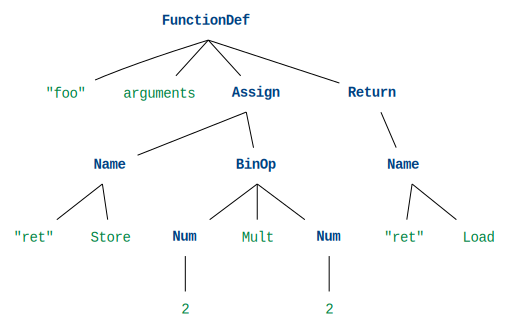

In [77]:
show_ast(tree)

You see that the function `foo()` has a `FunctionDef` node with four children: The function name (`"foo"`), its arguments (`arguments`; currently empty), followed by the statements that make the function body – `Assign` for the assignment, `Return` for the `return` statement.

We obtain and manipulate the AST through the Python modules `ast` and `astor`. The original Python `ast` reference is complete, but a bit brief; the documentation ["Green Tree Snakes - the missing Python AST docs"](https://greentreesnakes.readthedocs.io/en/latest/) provides an excellent introduction.

To instrument the above code, we need to insert a new statement as a child to `FunctionDef` node.

In [78]:
from ast import NodeTransformer, FunctionDef, fix_missing_locations

Here's the code we want to inject:

In [79]:
subtree_to_be_injected = ast.parse("print('entering function')")

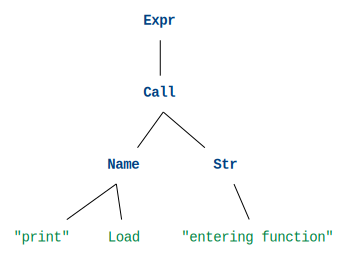

In [80]:
show_ast(subtree_to_be_injected)

The root of an `ast.parse()` tree actually is a `Module` node; we go directly to its child, which is the `Expr` node we want to inject.

In [81]:
subtree_to_be_injected = subtree_to_be_injected.body[0]

To inject the code, we use the `NodeTransformer` class as described in the Python `ast` documentation. We vist all function definitions (`FunctionDef`) and replace them with a new function definition in which the `body` gets an additional child – namely our subtree to be injected.

In [82]:
class InjectPass(NodeTransformer):
    def visit_FunctionDef(self, node):
        return FunctionDef(
            name=node.name,
            args=node.args,
            body=[subtree_to_be_injected] + node.body,
            decorator_list=node.decorator_list,
            returns=node.returns
        )

In [83]:
new_tree = fix_missing_locations(InjectPass().visit(tree))

This is what our new tree looks like:

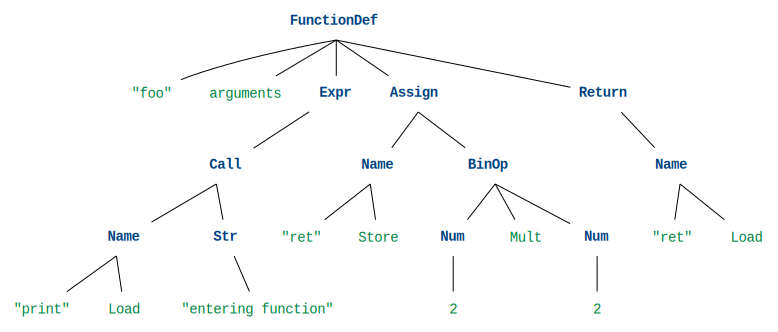

In [84]:
show_ast(new_tree)

This is what the tree looks like when converted back to source code:

In [85]:
new_source = astor.to_source(new_tree)
print_content(new_source, '.py')

def foo():
    print('entering function')
    ret = 2 * 2
    return ret

We can now compile the new source into a function:

In [86]:
exec(new_source)

... and happily invoke our instrumented function.

In [87]:
foo()

entering function


4

Your task is to implement a function `insert_tracer_ast(function, breakpoints)` that works like `insert_tracer()`, above, except that it uses this AST-based mechanism to inject debugging code into the given function.